In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv', index_col=None)
data

/var/folders/wc/rqgqs2ld2v9_r289z6535cx80000gn/T/ipykernel_28505/1611335262.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [2]:
from keras_tuner.tuners import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, Y = data.loc[:, ['long', 'lat']], data.loc[:, ['level']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [3]:
def build_model(hp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[2, 3]),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1], 1)))

    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss', 
    max_trials=20,     
    executions_per_trial=5,
    directory='keras_optimise_logs', 
    project_name='keras_tuning'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Trial 16 Complete [00h 00m 08s]
val_loss: 1.3194815397262574

Best val_loss So Far: 1.3180936336517335
Total elapsed time: 00h 01m 01s


In [4]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

best_model.evaluate(X_test, Y_test)

Epoch 1/50
224/224 [==============================] - 0s 757us/step - loss: 2.3739 - val_loss: 1.3200
Epoch 2/50
224/224 [==============================] - 0s 495us/step - loss: 1.3060 - val_loss: 1.3181
Epoch 3/50
224/224 [==============================] - 0s 504us/step - loss: 1.3066 - val_loss: 1.3181
Epoch 4/50
224/224 [==============================] - 0s 536us/step - loss: 1.3078 - val_loss: 1.3206
Epoch 5/50
224/224 [==============================] - 0s 498us/step - loss: 1.3075 - val_loss: 1.3182
Epoch 6/50
224/224 [==============================] - 0s 495us/step - loss: 1.3076 - val_loss: 1.3211
Epoch 7/50
224/224 [==============================] - 0s 543us/step - loss: 1.3062 - val_loss: 1.3181
Epoch 8/50
224/224 [==============================] - 0s 503us/step - loss: 1.3069 - val_loss: 1.3230
Epoch 9/50
224/224 [==============================] - 0s 493us/step - loss: 1.3079 - val_loss: 1.3191
Epoch 10/50
224/224 [==============================] - 0s 497us/step - loss: 1.306

1.3191100358963013

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = best_model.predict(X_test)

56/56 [==============================] - 0s 419us/step


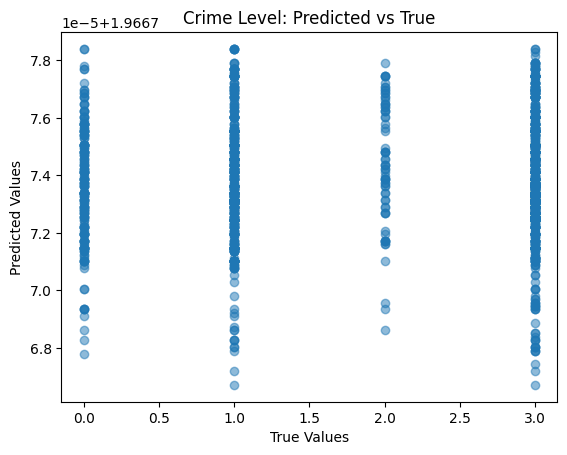

IndexError: single positional indexer is out-of-bounds

In [15]:
# Crime Level
plt.scatter(Y_test.iloc[:, 0], predictions[:, 0], alpha=0.5)
plt.title("Crime Level: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Longitude
plt.scatter(Y_test.iloc[:, 1], predictions[:, 1], alpha=0.5)
plt.title("Longitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Latitude
plt.scatter(Y_test.iloc[:, 2], predictions[:, 2], alpha=0.5)
plt.title("Latitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()